# Technical assessment

Kaggleのデータセットを使用してデータ分析や可視化、予測モデル検証などを実施する

https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/data


## Kaggle のデータをGoogle colabで利用するための処理

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import json
f = open("/content/drive/MyDrive/TechnicalChallenge/kaggle.json")
json_data = json.load(f)
os.environ['KAGGLE_USERNAME'] = json_data['username']
os.environ['KAGGLE_KEY'] = json_data['key']

In [ ]:
!kaggle datasets download -d mlg-ulb/creditcardfraud

creditcardfraud.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip -o '/content/creditcardfraud.zip'

Archive:  /content/creditcardfraud.zip
  inflating: creditcard.csv          


## 取得したKaggleのデータを分析する

In [ ]:
# 必要なパッケージをインポートする
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, train_test_split, cross_validate
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from imblearn.under_sampling import RandomUnderSampler

### pandasでcsvファイルを読み込む

In [ ]:
df = pd.read_csv('/content/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### データを要約してチェック

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

nullデータがないので欠損処理はしない

### 要約統計量を取得

In [ ]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


### ターゲットとなるClassをカウントする


In [ ]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

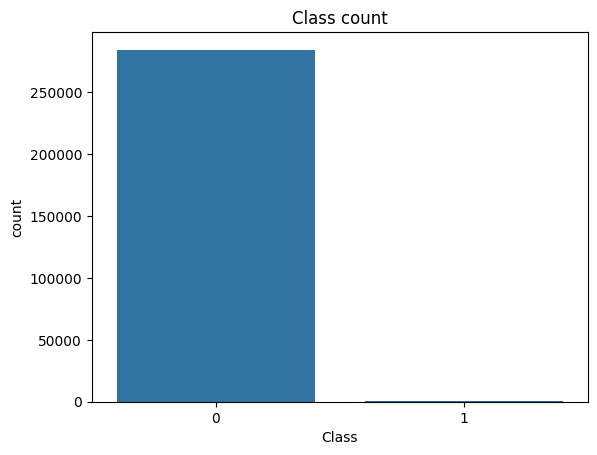

In [ ]:
sns.countplot(x='Class', data=df).set_title("Class count")
plt.show()

データの偏りがあることを確認した

### TimeとAmountを標準化する

In [ ]:
# TimeとAmountを標準化する
std_scaler = StandardScaler()

df_scaled = df.copy()

df_scaled['scaled_amount'] = std_scaler.fit_transform(df_scaled['Amount'].values.reshape(-1,1))
df_scaled['scaled_time'] = std_scaler.fit_transform(df_scaled['Time'].values.reshape(-1,1))

df_scaled.drop(['Time','Amount'], axis=1, inplace=True)

target_col = "Class"
df_target = df_scaled[target_col]

# 入れ替え対称の列を削除
df_scaled = df_scaled.drop(target_col, axis=1)

# 任意の場所に対象の列を挿入
df_scaled.insert(0, target_col, df_target)

df_scaled.head()

,Class,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,scaled_amount,scaled_time
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964,-1.996583
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342475,-1.996583
2,0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160686,-1.996562
3,0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534,-1.996562
4,0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403,-1.996541


In [ ]:
df_scaled.describe()

,Class,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,scaled_amount,scaled_time
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05
mean,0.001727,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,2.913952e-17,-3.065637e-16
std,0.041527,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,1.000002e+00,1.000002e+00
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,-3.532294e-01,-1.996583e+00
25%,0.000000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,-3.308401e-01,-8.552120e-01
50%,0.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,-2.652715e-01,-2.131453e-01
75%,0.000000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,-4.471707e-02,9.372174e-01
max,1.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,1.023622e+02,1.642058e+00


## 不均衡なデータをそのまま検証する

### ターゲットとなるClassと相関があるか検証

<Axes: >

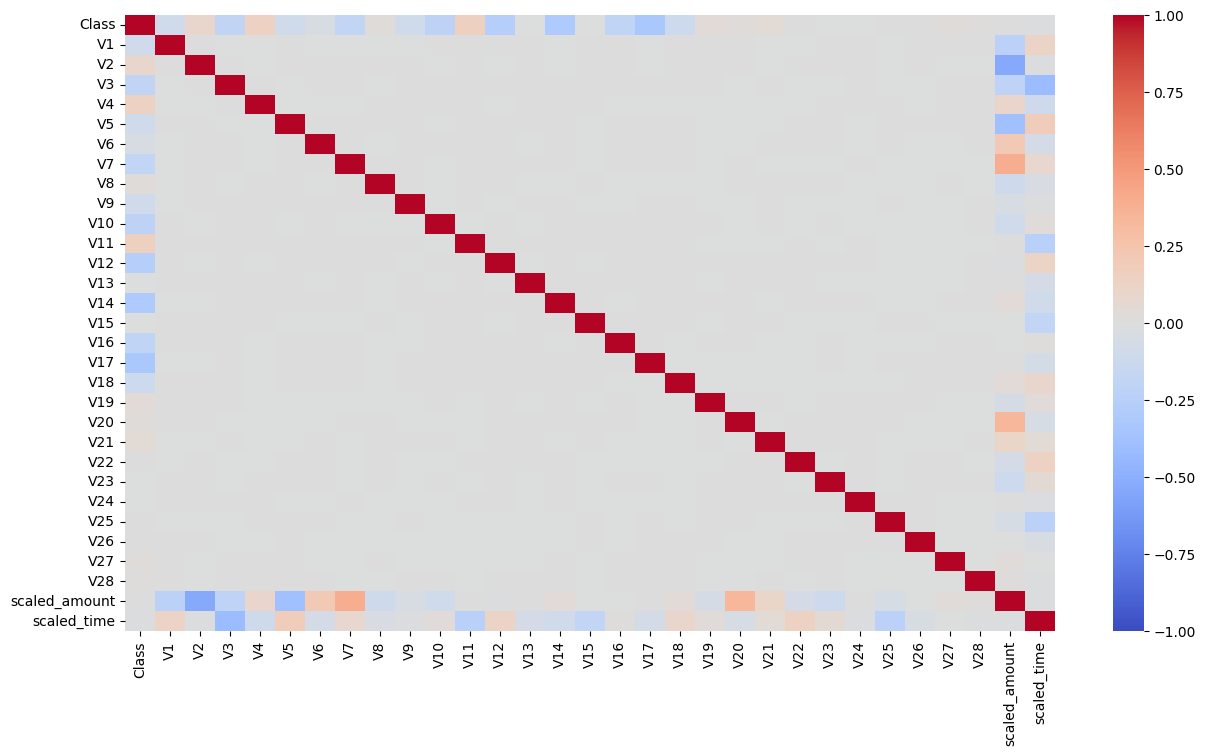

In [ ]:
df_corr = df_scaled.corr()
plt.figure(figsize=(15, 8))
sns.heatmap(df_corr, cmap='coolwarm', vmax=1.0,vmin=-1.0)

一部のデータがClassと弱い相関がありそう

In [ ]:
df_class_corr = df_corr['Class']
df_abs = df_class_corr.abs()
df_abs.sort_values(ascending=False)

Class            1.000000
V17              0.326481
V14              0.302544
V12              0.260593
V10              0.216883
V16              0.196539
V3               0.192961
V7               0.187257
V11              0.154876
V4               0.133447
V18              0.111485
V1               0.101347
V9               0.097733
V5               0.094974
V2               0.091289
V6               0.043643
V21              0.040413
V19              0.034783
V20              0.020090
V8               0.019875
V27              0.017580
scaled_time      0.012323
V28              0.009536
V24              0.007221
scaled_amount    0.005632
V13              0.004570
V26              0.004455
V15              0.004223
V25              0.003308
V23              0.002685
V22              0.000805
Name: Class, dtype: float64

### ライブラリを使ってクラス分類を行う

今回使うライブラリは、以下の3つ
* ロジスティック回帰
* K−近傍法
* 決定木



In [ ]:
# モデルのクロスバリデーションとモデル作成する関数
def model_fitting(model, X_train, X_test, y_train, y_test):

    scoring = ['accuracy', 'precision', 'recall', 'f1']

    scores = cross_validate(model, X_train, y_train, scoring=scoring)

    for key,value in scores.items():
        print("{}:{:.4f}".format(key, value.mean()))

    model.fit(X_train, y_train)
    Y_pred = model.predict(X_test)

    cnf_matrix = confusion_matrix(y_true=y_test, y_pred=Y_pred)

    DetaFrame_cm = pd.DataFrame(cnf_matrix)
    sns.heatmap(DetaFrame_cm, annot=True, fmt='d').set_title('Confusion matrix result')
    plt.xlabel('predicted value')
    plt.ylabel('true value')
    plt.show()

    print('accuracy = ', round(accuracy_score(y_true=y_test, y_pred=Y_pred) * 100, 2), '%')
    print('precision = ', round(precision_score(y_true=y_test, y_pred=Y_pred) * 100, 2), '%')
    print('recall = ', round(recall_score(y_true=y_test, y_pred=Y_pred) * 100, 2), '%')
    print('f1 score = ', round(f1_score(y_true=y_test, y_pred=Y_pred) * 100, 2), '%')

    return model

### 言葉の補足

- 真陽性（TP: True Positive）: 正例を正しく正例と判断
- 真陰性（TN: True Negative）: 負例を正しく負例と判断
- 偽陽性（FP: False Positive）: 負例を誤って正例と判断
- 偽陰性（FN: False Negative）: 正例を誤って負例と判断
- 正解率（accuracy）: 全サンプルのうち、分類したクラスと正解クラスが一致する数の割合
  - accuracy = (TP+TN)/(TP+FP+TN+FN)
- 適合率（precision）: positive と分類したサンプルのうち、正解した割合      
  - precision = TP/(TP+FP)
- 再現率（recall）: 正解ラベルが positive のサンプルのうち、分類ラベルも positive となった割合
  - recall = TP/(TP+FN)
- F1値（F1-measure）: 適合率 (Precision) 再現率 (Recall) をバランス良く持ち合わせているかを示す指標
  - F1 = 2 * (precision * recall) / (precision + recall) = 2 * TP / (2 * TP + FN + FP)

#### 学習データとテストデータに分ける

In [ ]:
X = df_scaled.drop('Class', axis=1)
y = df_scaled['Class']

# 80%のデータを学習データに、20%を検証データにする
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

#### ロジスティック回帰



In [ ]:
# ロジスティック回帰モデルの特徴量重要度を可視化する関数
def LR_regression_coefficients_per_feature(LR_model, X_train):
    coefs_df = pd.DataFrame(
        data={"coef": LR_model.coef_.squeeze().tolist()}, index=X_train.columns.tolist()
    ).sort_values("coef", ascending=True)

    plt.rcParams["axes.axisbelow"] = True
    plt.barh(coefs_df.index.to_list(), coefs_df["coef"].to_list(), align="center")

    plt.title("Regression coefficients per feature")
    plt.xlabel("regression coefficient")
    plt.ylabel("feature")
    plt.grid(visible=True)

    plt.show()

fit_time:4.0920
score_time:0.1734
test_accuracy:0.9992
test_precision:0.8776
test_recall:0.6140
test_f1:0.7204


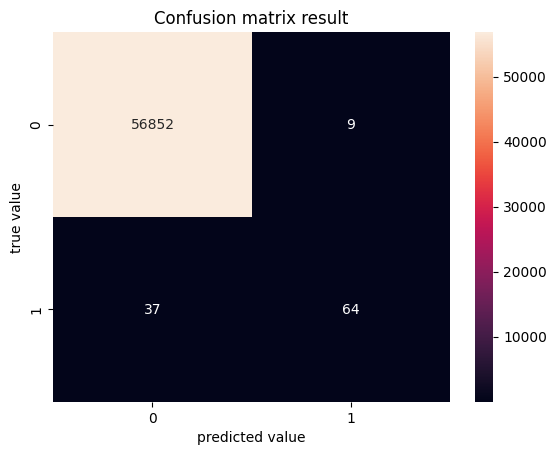

accuracy =  99.92 %
precision =  87.67 %
recall =  63.37 %
f1 score =  73.56 %


In [ ]:
LR_model = model_fitting(LogisticRegression(), X_train, X_test, y_train, y_test)

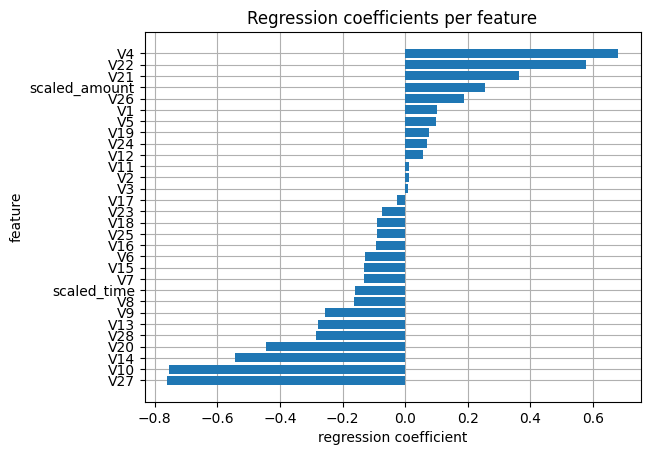

In [ ]:
LR_regression_coefficients_per_feature(LR_model, X_train)

#### K−近傍法

fit_time:0.0799
score_time:57.2918
test_accuracy:0.9995
test_precision:0.9242
test_recall:0.7596
test_f1:0.8329


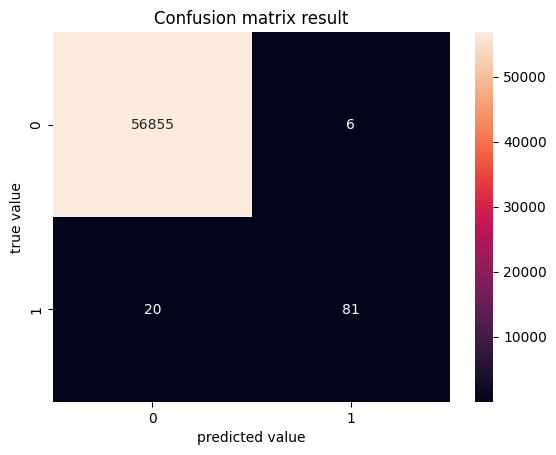

accuracy =  99.95 %
precision =  93.1 %
recall =  80.2 %
f1 score =  86.17 %


In [ ]:
KNC_model = model_fitting(KNeighborsClassifier(), X_train, X_test, y_train, y_test)

#### 決定木

In [ ]:
# 決定木の特徴量重要度を可視化する関数
def DTC_feature_importances(DTC_model, X_train):
    features = X_train.columns.values

    # 特徴量重要度
    importances = DTC_model.feature_importances_

    for n, v in zip(features, importances):
        print(f'importance of {n} is :{v}')

    # 可視化
    plt.figure(figsize=(14,4))
    plt.bar(height=importances, x=X_train.columns)
    plt.ylabel("Feature importances", color='tab:red', fontsize=16, labelpad=20, weight='bold')
    plt.xticks(rotation=90);

fit_time:19.2937
score_time:0.0619
test_accuracy:0.9992
test_precision:0.7470
test_recall:0.7647
test_f1:0.7554


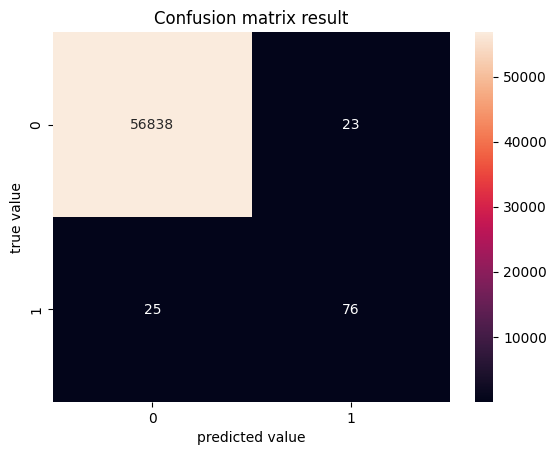

accuracy =  99.92 %
precision =  76.77 %
recall =  75.25 %
f1 score =  76.0 %


In [ ]:
DTC_model = model_fitting(DecisionTreeClassifier(), X_train, X_test, y_train, y_test)

importance of V1 is :0.01083416493852605
importance of V2 is :0.0
importance of V3 is :0.002562162706966074
importance of V4 is :0.009073352781735494
importance of V5 is :0.0030303746260742148
importance of V6 is :0.0037443756736471167
importance of V7 is :0.005106798583622634
importance of V8 is :0.0
importance of V9 is :0.005055722904253994
importance of V10 is :0.07472907483833648
importance of V11 is :0.011532147796825234
importance of V12 is :0.01045609659227443
importance of V13 is :0.012725059479061057
importance of V14 is :0.10805503710210304
importance of V15 is :0.005156965507767138
importance of V16 is :0.005491887554459556
importance of V17 is :0.5326494984633348
importance of V18 is :0.011236584431535667
importance of V19 is :0.012561452782055962
importance of V20 is :0.0163587625705152
importance of V21 is :0.013362324498714545
importance of V22 is :0.011641051877348773
importance of V23 is :0.002844469414008972
importance of V24 is :0.010346301203498607
importance of V25

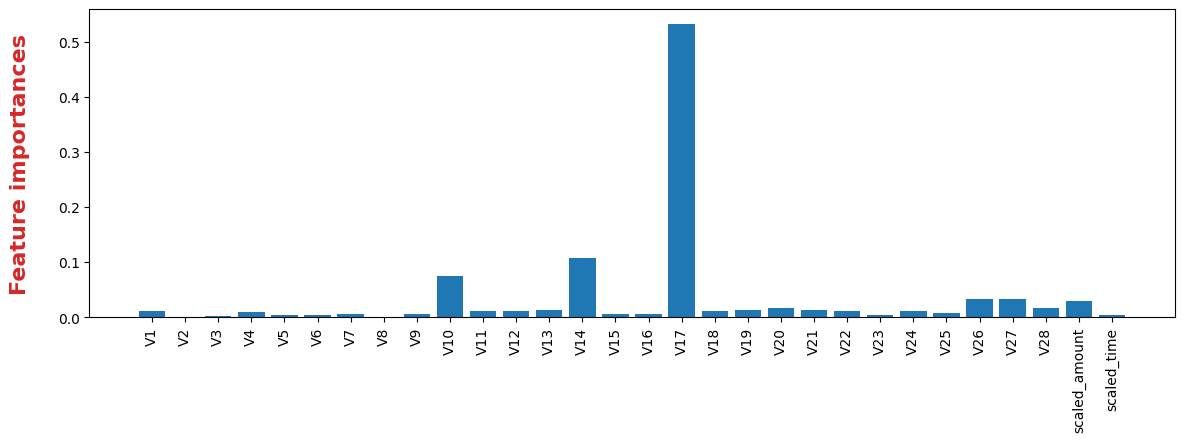

In [ ]:
DTC_feature_importances(DTC_model, X_train)

accuracyは非常に高い精度が出ているが、その他の項目がaccuracyほど高くないので、不均衡データをそのまま使うのは良くないと考えられる

## 不均衡なデータを均衡にするためにアンダーサンプリングをする

### データの比率を1対1にして検証

In [ ]:
# アンダーサンプリング
target = 'Class'
rs = RandomUnderSampler(random_state=0)
new_df ,_ = rs.fit_resample(df_scaled, df_scaled[target])

print('元データ')
print(df['Class'].value_counts())
print('-----' * 10)
print('アンダーサンプリング後のデータ')
print(new_df['Class'].value_counts())

元データ
0    284315
1       492
Name: Class, dtype: int64
--------------------------------------------------
アンダーサンプリング後のデータ
0    492
1    492
Name: Class, dtype: int64


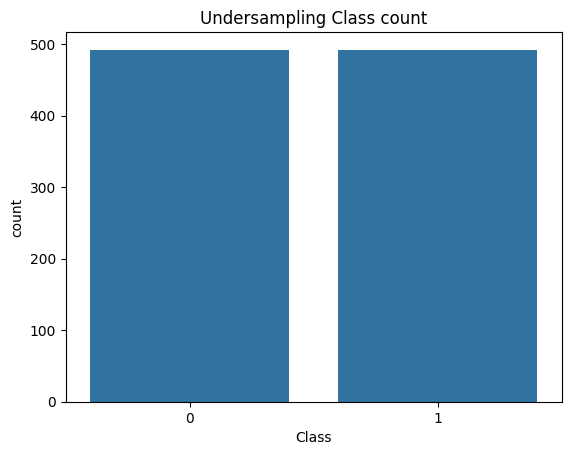

In [ ]:
sns.countplot(x='Class', data=new_df).set_title("Undersampling Class count")
plt.show()

In [ ]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 984 entries, 0 to 983
Data columns (total 31 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Class          984 non-null    int64  
 1   V1             984 non-null    float64
 2   V2             984 non-null    float64
 3   V3             984 non-null    float64
 4   V4             984 non-null    float64
 5   V5             984 non-null    float64
 6   V6             984 non-null    float64
 7   V7             984 non-null    float64
 8   V8             984 non-null    float64
 9   V9             984 non-null    float64
 10  V10            984 non-null    float64
 11  V11            984 non-null    float64
 12  V12            984 non-null    float64
 13  V13            984 non-null    float64
 14  V14            984 non-null    float64
 15  V15            984 non-null    float64
 16  V16            984 non-null    float64
 17  V17            984 non-null    float64
 18  V18       

In [ ]:
new_df.head()

,Class,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,scaled_amount,scaled_time
0,0,2.049094,0.186189,-1.707198,0.530768,0.160589,-1.448570,0.239310,-0.353611,0.634425,...,0.197782,0.741141,-0.009744,-0.085057,0.228384,-0.097292,-0.001028,-0.032390,-0.341275,1.418654
1,0,2.125540,-0.030714,-1.527653,0.121046,0.543172,-0.347988,0.157221,-0.229126,0.477999,...,-0.336497,-0.838932,0.275173,0.049145,-0.156765,0.205919,-0.072321,-0.059009,-0.345313,0.550731
2,0,-4.155859,-5.705748,0.274699,-0.993262,-6.059393,5.210848,5.811316,0.367888,1.750710,...,1.371671,1.195815,4.188762,-1.091077,1.033044,0.224493,-0.486741,0.194275,7.393702,-1.438885
3,0,-0.566420,-0.579576,0.823503,-1.451240,-0.583587,0.206381,1.601392,-0.370446,-1.910354,...,-0.065082,-0.761357,0.641524,-0.568974,-0.053164,-0.690995,-0.228630,-0.157254,0.926358,-0.612003
4,0,0.060858,-0.261762,-1.699493,-1.202327,3.699527,3.196249,0.437208,0.421541,0.492435,...,0.008303,0.534602,0.089602,0.667918,0.017798,0.611584,-0.469946,-0.514370,-0.307251,0.888879


In [ ]:
new_df.describe()

,Class,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,scaled_amount,scaled_time
count,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,...,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000
mean,0.500000,-2.348277,1.771160,-3.524154,2.331298,-1.591406,-0.660231,-2.764567,0.305558,-1.273717,...,0.357464,0.002179,-0.016766,-0.042024,0.032843,0.023745,0.072907,0.044551,0.099770,-0.180647
std,0.500254,5.564022,3.763435,6.222745,3.180415,4.226116,1.784683,5.876718,4.845736,2.326206,...,2.784858,1.163555,1.271166,0.565718,0.670075,0.486610,1.030118,0.430573,1.294105,0.993829
min,0.000000,-30.552380,-18.793329,-31.103685,-4.704106,-22.105532,-6.406267,-43.557242,-41.044261,-13.434066,...,-22.797604,-8.887017,-19.254328,-2.409839,-4.781606,-1.196621,-7.263482,-1.869290,-0.353229,-1.988034
25%,0.000000,-2.832488,-0.104964,-5.120349,0.053436,-1.840274,-1.484304,-3.060742,-0.202834,-2.345829,...,-0.159559,-0.521726,-0.228477,-0.383716,-0.298470,-0.312193,-0.070125,-0.059659,-0.348072,-1.033525
50%,0.500000,-0.795372,0.943748,-1.454437,1.321377,-0.400257,-0.643539,-0.625471,0.156482,-0.686031,...,0.146108,0.009078,-0.032094,0.016857,0.062719,-0.011590,0.040099,0.032732,-0.277266,-0.345863
75%,1.000000,1.103154,2.793742,0.372877,4.303707,0.450150,0.078152,0.250165,0.877002,0.208952,...,0.648533,0.553692,0.190576,0.359226,0.386614,0.323349,0.462040,0.225936,0.046539,0.758299
max,1.000000,2.296209,22.057729,4.069865,12.114672,11.095089,6.474115,16.303141,20.007208,5.133738,...,27.202839,8.361985,10.377233,1.347381,3.127398,2.745261,3.052358,3.572542,22.355900,1.599605


#### アンダーサンプリングしたデータでターゲットとなるClassとの相関をチェック

<Axes: >

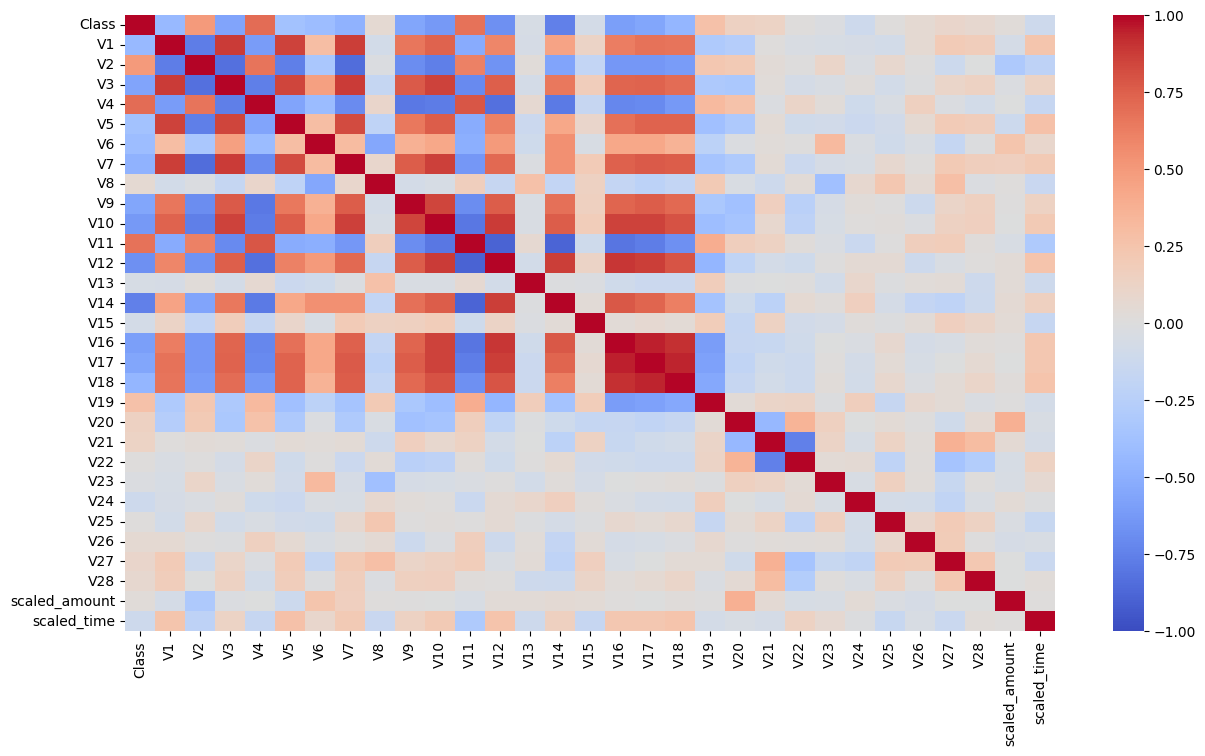

In [ ]:
new_df_corr = new_df.corr()
plt.figure(figsize=(15, 8))
sns.heatmap(new_df_corr, cmap='coolwarm', vmax=1.0,vmin=-1.0)

Classと相関がありそうな変数が増えた

In [ ]:
new_df_class_corr = new_df_corr['Class']
new_df_abs = new_df_class_corr.abs()
new_df_abs.sort_values(ascending=False)

Class            1.000000
V14              0.752780
V4               0.695461
V12              0.677721
V11              0.675015
V10              0.625531
V16              0.598540
V3               0.564206
V9               0.562319
V17              0.561523
V2               0.492518
V7               0.477408
V18              0.460874
V1               0.435819
V6               0.413452
V5               0.369278
V19              0.265922
V20              0.147698
V21              0.127944
scaled_time      0.116353
V24              0.111608
V27              0.094861
V15              0.077270
V28              0.072305
V26              0.057372
V8               0.054731
V13              0.054161
scaled_amount    0.027533
V23              0.018530
V25              0.012850
V22              0.010206
Name: Class, dtype: float64

いくつかの変数で強い相関がみられる

不均衡データの相関係数とアンダーサンプリングしたデータの相関係数を表示

In [ ]:
print(df_abs.sort_values(ascending=False))
print("----" * 10)
print(new_df_abs.sort_values(ascending=False))

Class            1.000000
V17              0.326481
V14              0.302544
V12              0.260593
V10              0.216883
V16              0.196539
V3               0.192961
V7               0.187257
V11              0.154876
V4               0.133447
V18              0.111485
V1               0.101347
V9               0.097733
V5               0.094974
V2               0.091289
V6               0.043643
V21              0.040413
V19              0.034783
V20              0.020090
V8               0.019875
V27              0.017580
scaled_time      0.012323
V28              0.009536
V24              0.007221
scaled_amount    0.005632
V13              0.004570
V26              0.004455
V15              0.004223
V25              0.003308
V23              0.002685
V22              0.000805
Name: Class, dtype: float64
----------------------------------------
Class            1.000000
V14              0.752780
V4               0.695461
V12              0.677721
V11              0.67

#### 1対1にアンダーサンプリングしたデータでクラス分類を実施

##### 学習データとテストデータに分ける

In [ ]:
X = new_df.drop('Class', axis=1)
y = new_df['Class']

# 80%のデータを学習データに、20%を検証データにする
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)


##### ロジスティック回帰

fit_time:0.0526
score_time:0.0172
test_accuracy:0.9403
test_precision:0.9645
test_recall:0.9119
test_f1:0.9372


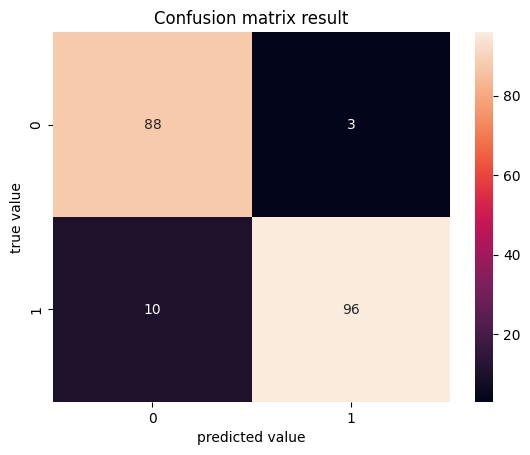

accuracy =  93.4 %
precision =  96.97 %
recall =  90.57 %
f1 score =  93.66 %


In [ ]:
LR_model = model_fitting(LogisticRegression(), X_train, X_test, y_train, y_test)

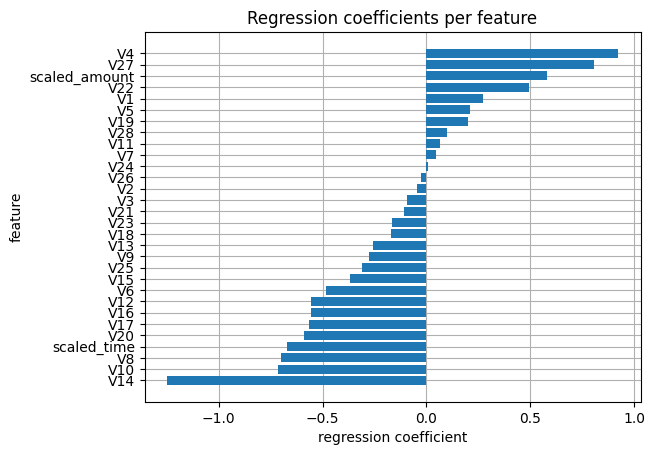

In [ ]:
LR_regression_coefficients_per_feature(LR_model, X_train)

##### K−近傍法

fit_time:0.0033
score_time:0.0204
test_accuracy:0.9415
test_precision:0.9801
test_recall:0.8989
test_f1:0.9377


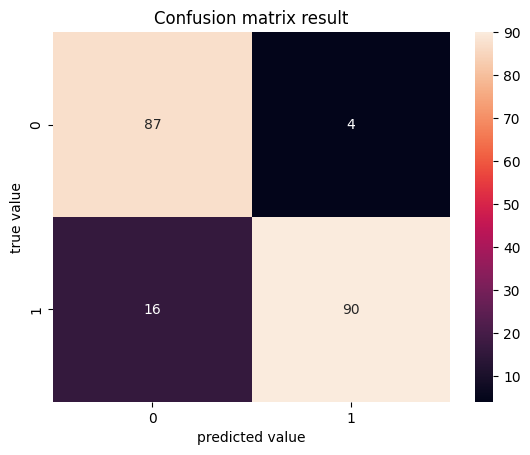

accuracy =  89.85 %
precision =  95.74 %
recall =  84.91 %
f1 score =  90.0 %


In [ ]:
KNC_model = model_fitting(KNeighborsClassifier(), X_train, X_test, y_train, y_test)

##### 決定木

fit_time:0.0154
score_time:0.0072
test_accuracy:0.9047
test_precision:0.8918
test_recall:0.9172
test_f1:0.9041


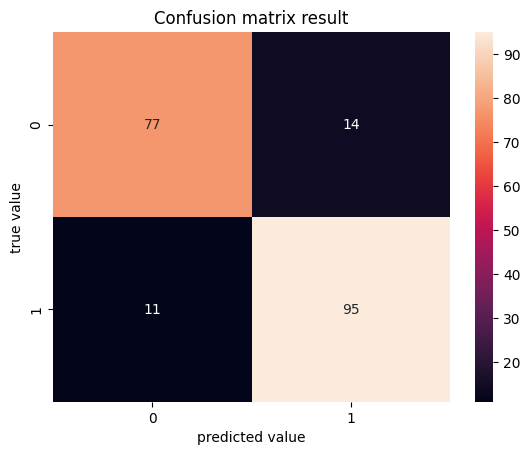

accuracy =  87.31 %
precision =  87.16 %
recall =  89.62 %
f1 score =  88.37 %


In [ ]:
DTC_model = model_fitting(DecisionTreeClassifier(), X_train, X_test, y_train, y_test)

importance of V1 is :0.0
importance of V2 is :0.008050362005177041
importance of V3 is :0.020527386077242013
importance of V4 is :0.054777305635435404
importance of V5 is :0.009477754126747777
importance of V6 is :0.01305731145412357
importance of V7 is :0.0051034379204214384
importance of V8 is :0.00726348451594921
importance of V9 is :0.0
importance of V10 is :0.003389626107442965
importance of V11 is :0.0062014750374808775
importance of V12 is :0.02241398841298405
importance of V13 is :0.0003219577974962593
importance of V14 is :0.7648684337115685
importance of V15 is :0.0
importance of V16 is :0.007292772759965212
importance of V17 is :0.004745476550420152
importance of V18 is :0.0
importance of V19 is :0.0
importance of V20 is :0.0
importance of V21 is :0.004148632192663798
importance of V22 is :0.005966080578212025
importance of V23 is :0.014424981172452339
importance of V24 is :0.003389626107442965
importance of V25 is :0.021057360072516428
importance of V26 is :0.00706167597998

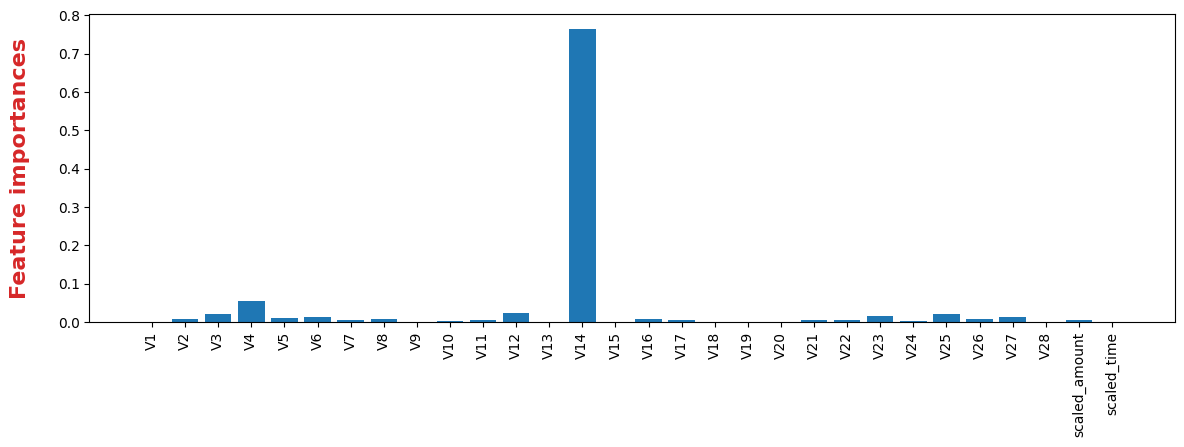

In [ ]:
DTC_feature_importances(DTC_model, X_train)

アンダーサンプリング前と同様にaccuracyは高い精度になっている

その他はアンダーサンプリング前と比べて精度が高くなった

今回の検証では、ロジスティック回帰モデルが一番良い結果となった

### アンダーサンプリングの比率を5対1にして検証

In [ ]:
# アンダーサンプリング
Class_1_count = df_scaled['Class'].value_counts()[1]

strategy = {0:Class_1_count*5, 1:Class_1_count}

rs = RandomUnderSampler(random_state=0, sampling_strategy = strategy)
new_df ,_ = rs.fit_resample(df_scaled, df_scaled['Class'])

print('元データ')
print(df['Class'].value_counts())
print('-----' * 10)
print('アンダーサンプリング後のデータ')
print(new_df['Class'].value_counts())

元データ
0    284315
1       492
Name: Class, dtype: int64
--------------------------------------------------
アンダーサンプリング後のデータ
0    2460
1     492
Name: Class, dtype: int64


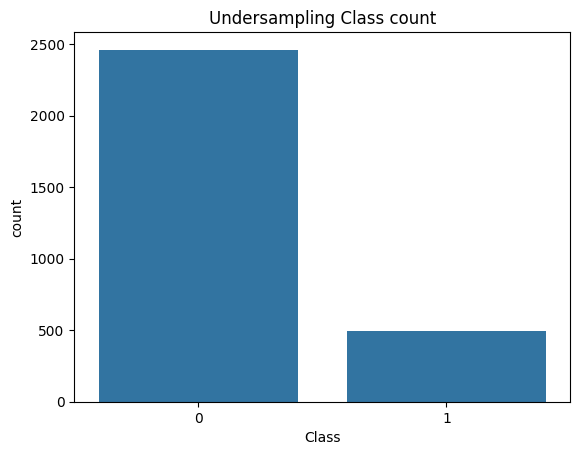

In [ ]:
sns.countplot(x='Class', data=new_df).set_title("Undersampling Class count")
plt.show()

In [ ]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2952 entries, 0 to 2951
Data columns (total 31 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Class          2952 non-null   int64  
 1   V1             2952 non-null   float64
 2   V2             2952 non-null   float64
 3   V3             2952 non-null   float64
 4   V4             2952 non-null   float64
 5   V5             2952 non-null   float64
 6   V6             2952 non-null   float64
 7   V7             2952 non-null   float64
 8   V8             2952 non-null   float64
 9   V9             2952 non-null   float64
 10  V10            2952 non-null   float64
 11  V11            2952 non-null   float64
 12  V12            2952 non-null   float64
 13  V13            2952 non-null   float64
 14  V14            2952 non-null   float64
 15  V15            2952 non-null   float64
 16  V16            2952 non-null   float64
 17  V17            2952 non-null   float64
 18  V18     

In [ ]:
new_df.head()

,Class,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,scaled_amount,scaled_time
0,0,2.049094,0.186189,-1.707198,0.530768,0.160589,-1.448570,0.239310,-0.353611,0.634425,...,0.197782,0.741141,-0.009744,-0.085057,0.228384,-0.097292,-0.001028,-0.032390,-0.341275,1.418654
1,0,2.125540,-0.030714,-1.527653,0.121046,0.543172,-0.347988,0.157221,-0.229126,0.477999,...,-0.336497,-0.838932,0.275173,0.049145,-0.156765,0.205919,-0.072321,-0.059009,-0.345313,0.550731
2,0,-4.155859,-5.705748,0.274699,-0.993262,-6.059393,5.210848,5.811316,0.367888,1.750710,...,1.371671,1.195815,4.188762,-1.091077,1.033044,0.224493,-0.486741,0.194275,7.393702,-1.438885
3,0,-0.566420,-0.579576,0.823503,-1.451240,-0.583587,0.206381,1.601392,-0.370446,-1.910354,...,-0.065082,-0.761357,0.641524,-0.568974,-0.053164,-0.690995,-0.228630,-0.157254,0.926358,-0.612003
4,0,0.060858,-0.261762,-1.699493,-1.202327,3.699527,3.196249,0.437208,0.421541,0.492435,...,0.008303,0.534602,0.089602,0.667918,0.017798,0.611584,-0.469946,-0.514370,-0.307251,0.888879


In [ ]:
new_df.describe()

,Class,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,scaled_amount,scaled_time
count,2952.000000,2952.000000,2952.000000,2952.000000,2952.000000,2952.000000,2952.000000,2952.000000,2952.000000,2952.000000,...,2952.000000,2952.000000,2952.000000,2952.000000,2952.000000,2952.000000,2952.000000,2952.000000,2952.000000,2952.000000
mean,0.166667,-0.710782,0.587817,-1.143632,0.822637,-0.521603,-0.212667,-0.921751,0.102747,-0.428419,...,0.115456,-0.003246,-0.017016,-0.008100,0.001698,0.014652,0.015796,0.014165,0.022071,-0.054661
std,0.372741,3.703125,2.605931,4.131070,2.434995,2.745842,1.488923,3.717148,2.925001,1.718484,...,1.680392,0.886868,0.865018,0.589472,0.563724,0.474932,0.685081,0.334341,1.014705,0.988511
min,0.000000,-30.552380,-19.730311,-31.103685,-4.704106,-22.105532,-7.494736,-43.557242,-41.044261,-13.434066,...,-22.797604,-8.887017,-19.254328,-2.704672,-4.781606,-1.301722,-7.263482,-3.713108,-0.353229,-1.995825
25%,0.000000,-1.215315,-0.477335,-1.569597,-0.670842,-0.890881,-0.903015,-0.840266,-0.207548,-1.015893,...,-0.210191,-0.547166,-0.181994,-0.354829,-0.317816,-0.306044,-0.068821,-0.053988,-0.335968,-0.895612
50%,0.000000,-0.203479,0.226033,-0.160984,0.313528,-0.144511,-0.377552,-0.076996,0.059385,-0.211479,...,0.004080,0.005443,-0.014097,0.033917,0.015163,-0.022292,0.008011,0.015959,-0.273268,-0.223422
75%,0.000000,1.251858,1.129974,0.912402,1.385508,0.576406,0.315049,0.471917,0.456282,0.519501,...,0.263193,0.521247,0.152495,0.408756,0.347804,0.277995,0.146320,0.108270,-0.018160,0.865041
max,1.000000,2.383325,22.057729,4.069865,12.114672,11.095089,7.478806,16.303141,20.007208,7.929051,...,27.202839,8.361985,10.377233,3.208814,3.127398,2.745261,3.480944,3.731441,22.355900,1.638162


#### 相関チェック

<Axes: >

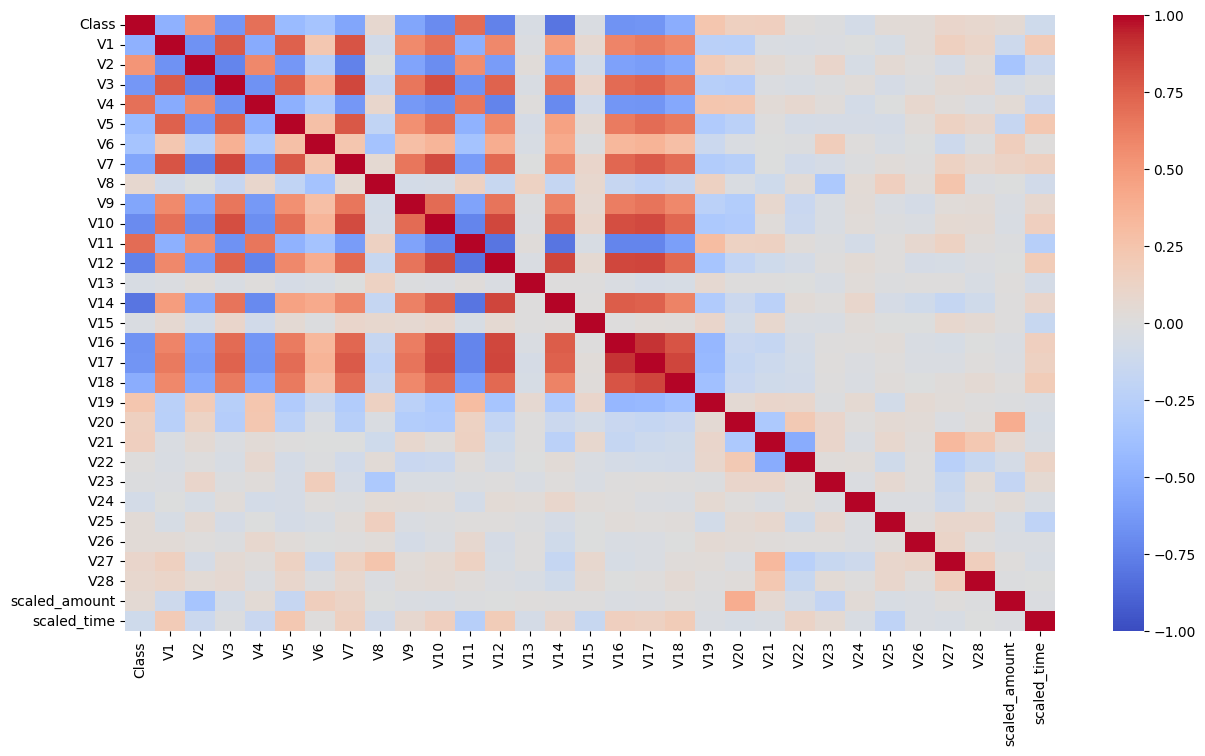

In [ ]:
new_df_corr = new_df.corr()
plt.figure(figsize=(15, 8))
sns.heatmap(new_df_corr, cmap='coolwarm', vmax=1.0,vmin=-1.0)

In [ ]:
new_df_class_corr = new_df_corr['Class']
new_df_abs = new_df_class_corr.abs()
new_df_abs.sort_values(ascending=False)

Class            1.000000
V14              0.804797
V12              0.743636
V11              0.703004
V10              0.697142
V4               0.683223
V16              0.662217
V17              0.649069
V3               0.637698
V9               0.560309
V7               0.559177
V2               0.521101
V18              0.512617
V1               0.490536
V5               0.428357
V6               0.356008
V19              0.239660
V21              0.159212
V20              0.155543
scaled_time      0.109304
V27              0.101055
V28              0.082279
V24              0.073626
V8               0.071549
scaled_amount    0.049949
V13              0.039931
V26              0.034843
V25              0.031540
V15              0.030579
V23              0.012044
V22              0.008723
Name: Class, dtype: float64

#### 5対1にアンダーサンプリングしたデータでクラス分類を実施

##### 学習データとテストデータに分ける

In [ ]:
X = new_df.drop('Class', axis=1)
y = new_df['Class']

# 80%のデータを学習データに、20%を検証データにする
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

##### ロジスティック回帰

fit_time:0.0389
score_time:0.0105
test_accuracy:0.9716
test_precision:0.9548
test_recall:0.8737
test_f1:0.9118


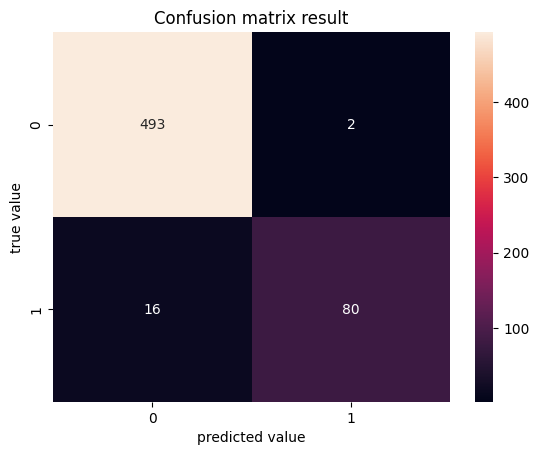

accuracy =  96.95 %
precision =  97.56 %
recall =  83.33 %
f1 score =  89.89 %


In [ ]:
LR_model = model_fitting(LogisticRegression(), X_train, X_test, y_train, y_test)

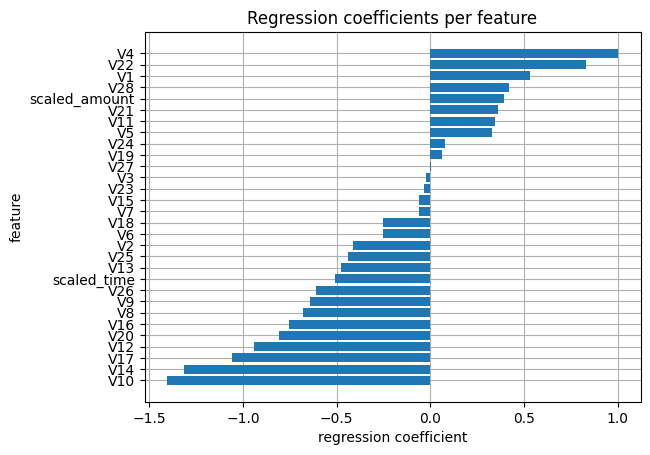

In [ ]:
LR_regression_coefficients_per_feature(LR_model, X_train)

##### K-近傍法

fit_time:0.0035
score_time:0.0468
test_accuracy:0.9742
test_precision:0.9701
test_recall:0.8737
test_f1:0.9190


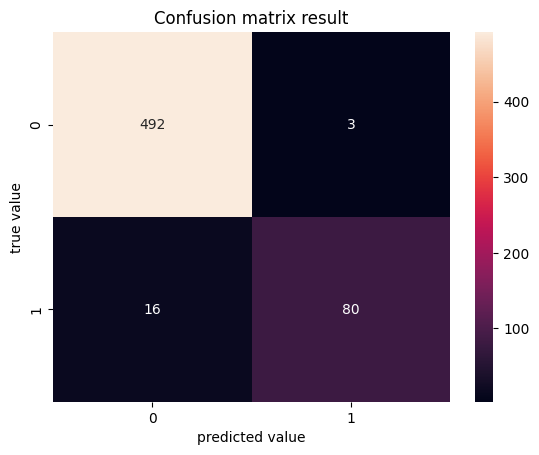

accuracy =  96.79 %
precision =  96.39 %
recall =  83.33 %
f1 score =  89.39 %


In [ ]:
KNC_model = model_fitting(KNeighborsClassifier(), X_train, X_test, y_train, y_test)

##### 決定木

fit_time:0.0839
score_time:0.0078
test_accuracy:0.9610
test_precision:0.8858
test_recall:0.8813
test_f1:0.8833


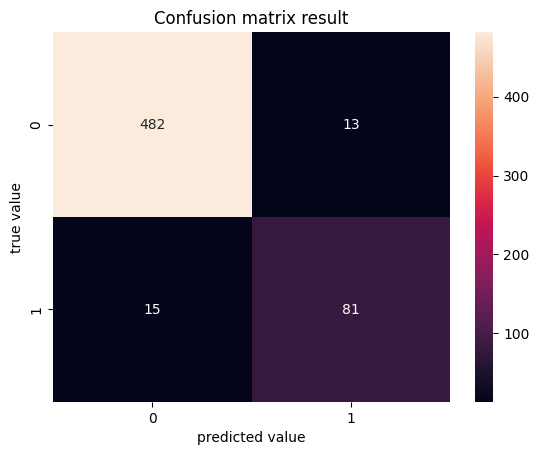

accuracy =  95.26 %
precision =  86.17 %
recall =  84.38 %
f1 score =  85.26 %


In [ ]:
DTC_model = model_fitting(DecisionTreeClassifier(), X_train, X_test, y_train, y_test)

importance of V1 is :0.008853365249785358
importance of V2 is :0.0
importance of V3 is :0.008316023908494412
importance of V4 is :0.009377554331333878
importance of V5 is :0.0058287426453176115
importance of V6 is :0.0
importance of V7 is :0.014247049339792492
importance of V8 is :0.002528465314724856
importance of V9 is :0.0015170791888349136
importance of V10 is :0.000975265192822442
importance of V11 is :0.0013775145573181975
importance of V12 is :0.015019083969465646
importance of V13 is :0.013487678755401498
importance of V14 is :0.8053263025774184
importance of V15 is :0.010301141057795457
importance of V16 is :0.0009439603841639376
importance of V17 is :0.03312217074289284
importance of V18 is :0.0
importance of V19 is :0.011371698333985911
importance of V20 is :0.013655632429378142
importance of V21 is :0.0005070335660544158
importance of V22 is :0.0049557920168607165
importance of V23 is :0.0028337557905223246
importance of V24 is :0.009027756959992132
importance of V25 is :0.

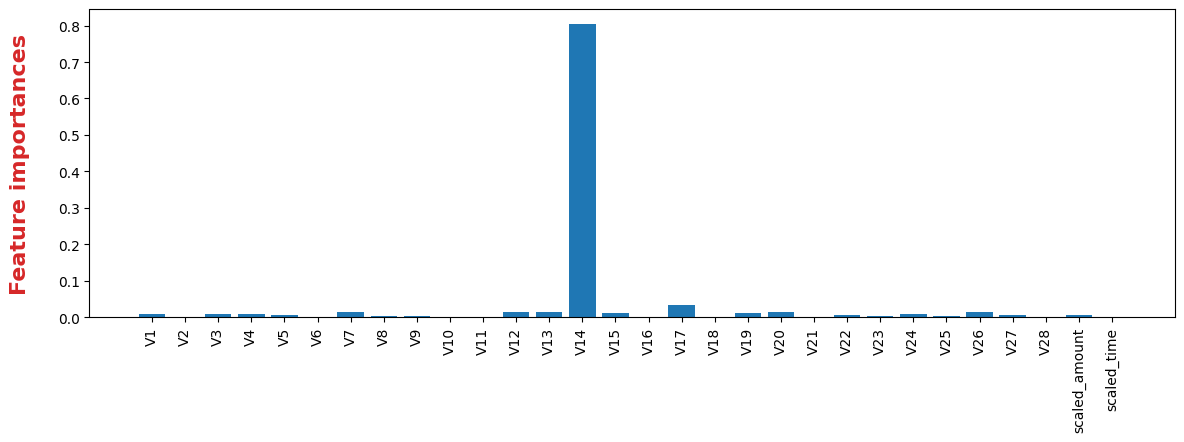

In [ ]:
DTC_feature_importances(DTC_model, X_train)

## まとめ

今回の検証では、以下のことが分かった
- ロジスティック回帰モデルを使用すると正解率が高い
- Classに大きく影響を与えている特徴は、V4, V10, V12, V14, V17の５つと考えられる
- データ量が不均衡だとAccuracyの数値は高くとも、F1 scoreが高い数値とは言えない結果になったので、良いモデルは作れないだろう
- データ量を調整して、均衡なデータ使用してモデルを作る必要があると考えられる

# 残りの検証

- アンダーサンプリングの比率調整
- クラス分類モデルのパラメーター調整
- オーバーサンプリングによるデータ量調整
- ニューラルネットワークなどを使用した別のモデルを作成

## アンダーサンプリングの比率調整

* ターゲットとなるデータの比率を調整することによって結果が変わることが分かった
* 適当な比率に調整することによって適したモデルを作ることが可能だと考えられる

## クラス分類モデルのパラメーター調整

- 今回はパラメーターを調整せずにデフォルト値を用いて検証した
- モデルのパラメーターを調整することで高い精度が期待できると考える

## オーバーサンプリングによるデータ量調整

- 今回の検証ではアンダーサンプリングを用いて、ターゲットのデータ数を調整した
- オーバーサンプリングで少数派のデータを増やし、多数派のデータと同量にして検証することもできる
- アンダーサンプリングとオーバーサンプリングを比較してどちらで調整することが適切なのか検証する必要がある

## ニューラルネットワークなどを使用した別のモデルを作成

- 今回はsklearnを使用した既存のモデルをもとに検証をした
- ニューラルネットワークを用いたモデルで検証することで今回のモデルよりも良い結果が出るかもしれない